In [ ]:
!pip install geopy requests pandas tqdm

In [ ]:
import pandas as pd
import time
import json
import requests
from geopy.geocoders import Nominatim
from tqdm import tqdm

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_clean.csv' , sep=";")
df.head()


,Ville,Quartier,Prix,Type de Bien,Surface,Nombre de Chambres,Nombre de Salles de Bain,Etage,Terrasse,Garage,Ascenseur,Piscine,Securite
0,agadir,haut founty,1750000.0,appartement,107.0,2.0,2.0,5.0,0,0,1,0,1
1,agadir,founti,1282240.0,local commercial,110.0,0.0,1.0,1.0,0,0,0,0,1
2,agadir,al wifaq,250000.0,local commercial,188.0,0.0,3.0,1.0,0,0,1,0,1
3,agadir,ben serguaou,13900000.0,riad,430.0,5.0,4.0,0.0,1,1,0,1,1
4,agadir,charaf,2200000.0,appartement,150.0,8.0,2.0,3.0,1,1,1,0,0


In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [ ]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)
df.columns

Index(['ville', 'quartier', 'prix', 'type_de_bien', 'surface',
       'nombre_de_chambres', 'nombre_de_salles_de_bain', 'etage', 'terrasse',
       'garage', 'ascenseur', 'piscine', 'securite'],
      dtype='object')

In [ ]:
df['ville'] = df['ville'].replace('fs', 'fes')

In [ ]:
# Normalisation + création clé Quartier
def normalize(x):
    if pd.isna(x):
        return ""
    return str(x).lower().strip()

df["quartier_key"] = (
    df["ville"].apply(normalize) + "_" +
    df["quartier"].apply(normalize)
)

len(df["quartier_key"].unique())


527

In [ ]:
df["quartier_key"].head(10)


,quartier_key
0,agadir_haut founty
1,agadir_founti
2,agadir_al wifaq
3,agadir_ben serguaou
4,agadir_charaf
5,agadir_hay houda
6,agadir_abattoirs
7,agadir_hay houda
8,agadir_ben serguaou
9,agadir_charaf


In [ ]:
df_q = pd.read_excel("/content/drive/MyDrive/dataset_geocode.xlsx")
df_q.head()


,quartier_key,lat,lon
0,agadir_haut founty,30.417131,-9.599245
1,agadir_founti,30.395814,-9.580752
2,agadir_al wifaq,30.417131,-9.599245
3,agadir_ben serguaou,30.389583,-9.575926
4,agadir_charaf,30.417131,-9.599245


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17805 entries, 0 to 17804
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ville                     17805 non-null  object 
 1   quartier                  17805 non-null  object 
 2   prix                      17805 non-null  float64
 3   type_de_bien              17805 non-null  object 
 4   surface                   17805 non-null  float64
 5   nombre_de_chambres        17805 non-null  float64
 6   nombre_de_salles_de_bain  17805 non-null  float64
 7   etage                     17805 non-null  float64
 8   terrasse                  17805 non-null  int64  
 9   garage                    17805 non-null  int64  
 10  ascenseur                 17805 non-null  int64  
 11  piscine                   17805 non-null  int64  
 12  securite                  17805 non-null  int64  
 13  quartier_key              17805 non-null  object 
dtypes: flo

In [ ]:
print("\nValeurs manquantes :", df_q.isnull().sum()  )


Valeurs manquantes : quartier_key    0
lat             0
lon             0
dtype: int64


In [ ]:
print("Colonnes df :", df.columns.tolist())
print("Colonnes df_q :", df_q.columns.tolist())


Colonnes df : ['ville', 'quartier', 'prix', 'type_de_bien', 'surface', 'nombre_de_chambres', 'nombre_de_salles_de_bain', 'etage', 'terrasse', 'garage', 'ascenseur', 'piscine', 'securite', 'quartier_key']
Colonnes df_q : ['quartier_key', 'lat', 'lon']


In [ ]:
df_enrichie = pd.read_excel("/content/drive/MyDrive/dataset_enrichi.xlsx")
df_enrichie.head()

,quartier_key,lat,lon,nb_ecoles,nb_hopitaux,nb_pharmacies,nb_mosquees,nb_banques,nb_centres_commerciaux
0,agadir_haut founty,30.417131,-9.599245,8,5,29,7,32,1
1,agadir_founti,30.395814,-9.580752,11,1,21,2,4,2
2,agadir_al wifaq,30.417131,-9.599245,8,5,29,7,32,1
3,agadir_ben serguaou,30.389583,-9.575926,10,1,22,4,1,2
4,agadir_charaf,30.417131,-9.599245,8,5,29,7,32,1


In [ ]:
df_enrichie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   quartier_key            527 non-null    object 
 1   lat                     527 non-null    float64
 2   lon                     527 non-null    float64
 3   nb_ecoles               527 non-null    int64  
 4   nb_hopitaux             527 non-null    int64  
 5   nb_pharmacies           527 non-null    int64  
 6   nb_mosquees             527 non-null    int64  
 7   nb_banques              527 non-null    int64  
 8   nb_centres_commerciaux  527 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 37.2+ KB


In [ ]:
print("\nValeurs manquantes :", df_enrichie.isnull().sum()  )


Valeurs manquantes : quartier_key              0
lat                       0
lon                       0
nb_ecoles                 0
nb_hopitaux               0
nb_pharmacies             0
nb_mosquees               0
nb_banques                0
nb_centres_commerciaux    0
dtype: int64


In [ ]:
import pandas as pd

print(f"Nombre de lignes avant fusion: {len(df)}")

df_merged = df.merge(df_enrichie, on='quartier_key', how='left')

print(f"Nombre de lignes après fusion: {len(df_merged)}")

print(f"\n Vérification des valeurs nulles:")
print(df_merged.isnull().sum())

Nombre de lignes avant fusion: 17805
Nombre de lignes après fusion: 17805

 Vérification des valeurs nulles:
ville                       0
quartier                    0
prix                        0
type_de_bien                0
surface                     0
nombre_de_chambres          0
nombre_de_salles_de_bain    0
etage                       0
terrasse                    0
garage                      0
ascenseur                   0
piscine                     0
securite                    0
quartier_key                0
lat                         0
lon                         0
nb_ecoles                   0
nb_hopitaux                 0
nb_pharmacies               0
nb_mosquees                 0
nb_banques                  0
nb_centres_commerciaux      0
dtype: int64


In [ ]:
print(df_merged.head())

    ville      quartier        prix      type_de_bien  surface  \
0  agadir   haut founty   1750000.0       appartement    107.0   
1  agadir        founti   1282240.0  local commercial    110.0   
2  agadir      al wifaq    250000.0  local commercial    188.0   
3  agadir  ben serguaou  13900000.0              riad    430.0   
4  agadir        charaf   2200000.0       appartement    150.0   

   nombre_de_chambres  nombre_de_salles_de_bain  etage  terrasse  garage  ...  \
0                 2.0                       2.0    5.0         0       0  ...   
1                 0.0                       1.0    1.0         0       0  ...   
2                 0.0                       3.0    1.0         0       0  ...   
3                 5.0                       4.0    0.0         1       1  ...   
4                 8.0                       2.0    3.0         1       1  ...   

   securite         quartier_key        lat       lon  nb_ecoles  nb_hopitaux  \
0         1   agadir_haut founty  3

In [ ]:
# Sauvegarde du dataset final
df_merged.to_csv("df_final.csv", index=False, encoding="utf-8")

In [ ]:
!pip install pandas numpy matplotlib seaborn scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/df_final.csv", encoding="utf-8", sep=",")

In [ ]:
print(f" Dimensions du dataset: {df.shape[0]} lignes × {df.shape[1]} colonnes")

 Dimensions du dataset: 17805 lignes × 22 colonnes


In [ ]:
print("Colonnes df :", df.columns.tolist())

Colonnes df : ['ville', 'quartier', 'prix', 'type_de_bien', 'surface', 'nombre_de_chambres', 'nombre_de_salles_de_bain', 'etage', 'terrasse', 'garage', 'ascenseur', 'piscine', 'securite', 'quartier_key', 'lat', 'lon', 'nb_ecoles', 'nb_hopitaux', 'nb_pharmacies', 'nb_mosquees', 'nb_banques', 'nb_centres_commerciaux']


In [ ]:
df.head()

,ville,quartier,prix,type_de_bien,surface,nombre_de_chambres,nombre_de_salles_de_bain,etage,terrasse,garage,...,securite,quartier_key,lat,lon,nb_ecoles,nb_hopitaux,nb_pharmacies,nb_mosquees,nb_banques,nb_centres_commerciaux
0,agadir,haut founty,1750000.0,appartement,107.0,2.0,2.0,5.0,0,0,...,1,agadir_haut founty,30.417131,-9.599245,8,5,29,7,32,1
1,agadir,founti,1282240.0,local commercial,110.0,0.0,1.0,1.0,0,0,...,1,agadir_founti,30.395814,-9.580752,11,1,21,2,4,2
2,agadir,al wifaq,250000.0,local commercial,188.0,0.0,3.0,1.0,0,0,...,1,agadir_al wifaq,30.417131,-9.599245,8,5,29,7,32,1
3,agadir,ben serguaou,13900000.0,riad,430.0,5.0,4.0,0.0,1,1,...,1,agadir_ben serguaou,30.389583,-9.575926,10,1,22,4,1,2
4,agadir,charaf,2200000.0,appartement,150.0,8.0,2.0,3.0,1,1,...,0,agadir_charaf,30.417131,-9.599245,8,5,29,7,32,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17805 entries, 0 to 17804
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ville                     17805 non-null  object 
 1   quartier                  17805 non-null  object 
 2   prix                      17805 non-null  float64
 3   type_de_bien              17805 non-null  object 
 4   surface                   17805 non-null  float64
 5   nombre_de_chambres        17805 non-null  float64
 6   nombre_de_salles_de_bain  17805 non-null  float64
 7   etage                     17805 non-null  float64
 8   terrasse                  17805 non-null  int64  
 9   garage                    17805 non-null  int64  
 10  ascenseur                 17805 non-null  int64  
 11  piscine                   17805 non-null  int64  
 12  securite                  17805 non-null  int64  
 13  quartier_key              17805 non-null  object 
 14  lat   

In [ ]:
df.describe(include='all')

,ville,quartier,prix,type_de_bien,surface,nombre_de_chambres,nombre_de_salles_de_bain,etage,terrasse,garage,...,securite,quartier_key,lat,lon,nb_ecoles,nb_hopitaux,nb_pharmacies,nb_mosquees,nb_banques,nb_centres_commerciaux
count,17805,17805,1.780500e+04,17805,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,...,17805.000000,17805,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000,17805.000000
unique,6,502,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,casablanca,gueliz,NaN,appartement,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,marrakech_gueliz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7244,922,NaN,9165,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4.624515e+06,NaN,802.451278,2.563044,2.135411,1.700197,0.518338,0.550800,...,0.375232,NaN,32.924107,-7.632264,14.587700,2.890873,28.526650,10.050885,34.105981,0.863578
std,NaN,NaN,8.495364e+06,NaN,3598.960954,2.595973,2.390708,1.951093,0.499678,0.497427,...,0.484196,NaN,1.498529,0.977210,13.209565,3.051208,18.321204,7.449945,41.404330,0.947084
min,NaN,NaN,7.500000e+03,NaN,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,29.596900,-9.823240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,1.100000e+06,NaN,87.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,31.622506,-8.009374,4.000000,1.000000,15.000000,5.000000,3.000000,0.000000
50%,NaN,NaN,2.100000e+06,NaN,140.000000,2.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,NaN,33.548838,-7.643031,10.000000,2.000000,26.000000,9.000000,21.000000,1.000000
75%,NaN,NaN,4.600000e+06,NaN,360.000000,4.000000,3.000000,3.000000,1.000000,1.000000,...,1.000000,NaN,33.589982,-7.572284,24.000000,4.000000,43.000000,12.000000,48.000000,1.000000


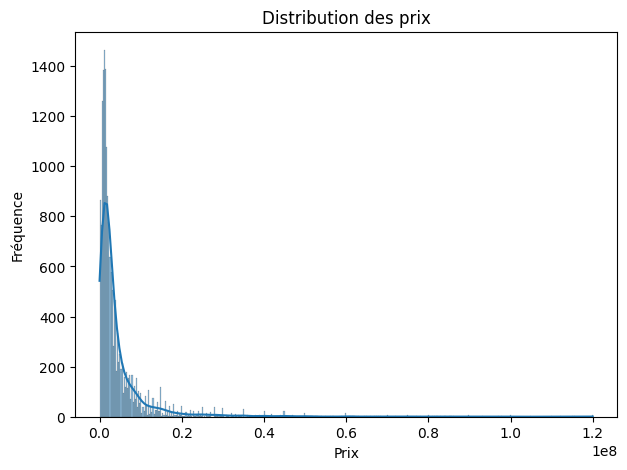

In [ ]:
plt.figure(figsize=(7,5))
sns.histplot(df['prix'], kde=True)
plt.title("Distribution des prix")
plt.xlabel("Prix")
plt.ylabel("Fréquence")
plt.show()

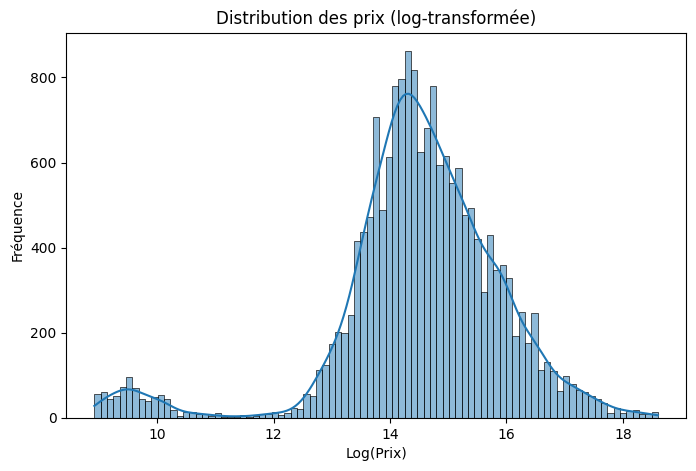

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(np.log(df['prix'] + 1), kde=True)   # +1 pour éviter log(0)
plt.title("Distribution des prix (log-transformée)")
plt.xlabel("Log(Prix)")
plt.ylabel("Fréquence")
plt.show()

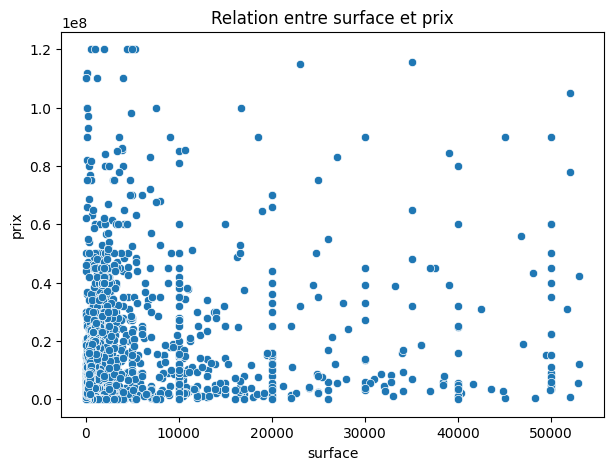

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="surface", y="prix")
plt.title("Relation entre surface et prix")
plt.show()


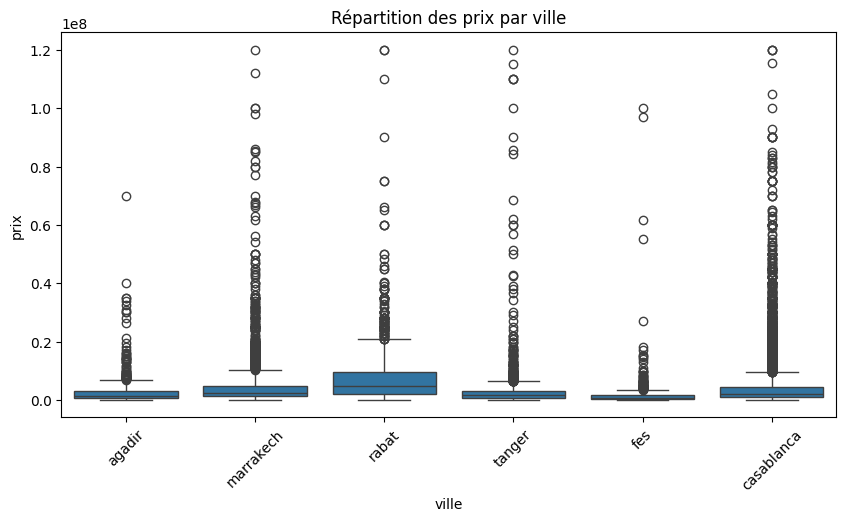

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="ville", y="prix")
plt.xticks(rotation=45)
plt.title("Répartition des prix par ville")
plt.show()


In [ ]:
type_de_bien_counts = df["type_de_bien"].value_counts()
type_de_bien_percent = df["type_de_bien"].value_counts(normalize=True) * 100

print("Distribution absolue :\n", type_de_bien_counts)
print("\nPourcentage :\n", type_de_bien_percent)

Distribution absolue :
 type_de_bien
appartement         9165
villa               3392
terrain             1907
local commercial    1318
maison               879
bureau               598
riad                 527
logement              19
Name: count, dtype: int64

Pourcentage :
 type_de_bien
appartement         51.474305
villa               19.050828
terrain             10.710475
local commercial     7.402415
maison               4.936816
bureau               3.358607
riad                 2.959843
logement             0.106712
Name: proportion, dtype: float64


In [ ]:
df = df[df["type_de_bien"] != "logement"]

In [ ]:
type_de_bien_counts = df["type_de_bien"].value_counts()
type_de_bien_counts

,count
type_de_bien,
appartement,9165
villa,3392
terrain,1907
local commercial,1318
maison,879
bureau,598
riad,527


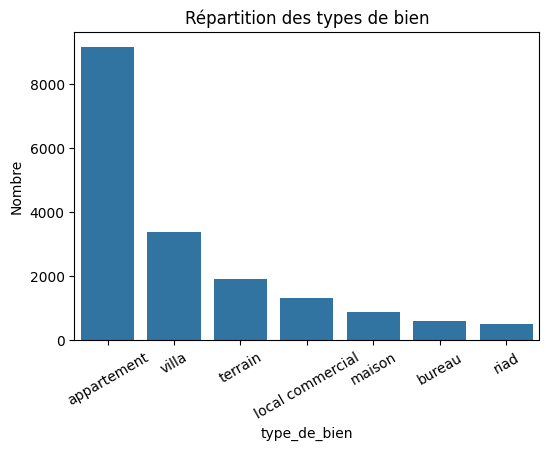

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=type_de_bien_counts.index, y=type_de_bien_counts.values)
plt.title("Répartition des types de bien")
plt.ylabel("Nombre")
plt.xticks(rotation=30)
plt.show()

In [ ]:
prix_m2_quartier = df.groupby(['ville', 'quartier']).apply(
    lambda x: x['prix'].sum() / x['surface'].sum()
).reset_index(name='prix_m2_quartier')

df = df.merge(prix_m2_quartier, on=['ville', 'quartier'], how='left')

/tmp/ipython-input-1696928291.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prix_m2_quartier = df.groupby(['ville', 'quartier']).apply(


In [ ]:
df.head()

,ville,quartier,prix,type_de_bien,surface,nombre_de_chambres,nombre_de_salles_de_bain,etage,terrasse,garage,...,quartier_key,lat,lon,nb_ecoles,nb_hopitaux,nb_pharmacies,nb_mosquees,nb_banques,nb_centres_commerciaux,prix_m2_quartier
0,agadir,haut founty,1750000.0,appartement,107.0,2.0,2.0,5.0,0,0,...,agadir_haut founty,30.417131,-9.599245,8,5,29,7,32,1,10778.533510
1,agadir,founti,1282240.0,local commercial,110.0,0.0,1.0,1.0,0,0,...,agadir_founti,30.395814,-9.580752,11,1,21,2,4,2,16885.607698
2,agadir,al wifaq,250000.0,local commercial,188.0,0.0,3.0,1.0,0,0,...,agadir_al wifaq,30.417131,-9.599245,8,5,29,7,32,1,15416.231506
3,agadir,ben serguaou,13900000.0,riad,430.0,5.0,4.0,0.0,1,1,...,agadir_ben serguaou,30.389583,-9.575926,10,1,22,4,1,2,5459.825886
4,agadir,charaf,2200000.0,appartement,150.0,8.0,2.0,3.0,1,1,...,agadir_charaf,30.417131,-9.599245,8,5,29,7,32,1,18516.058394


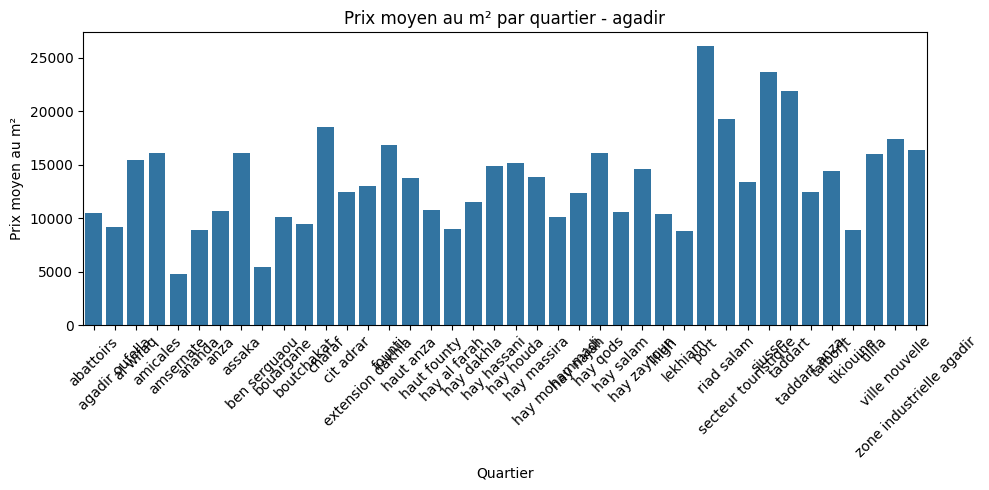

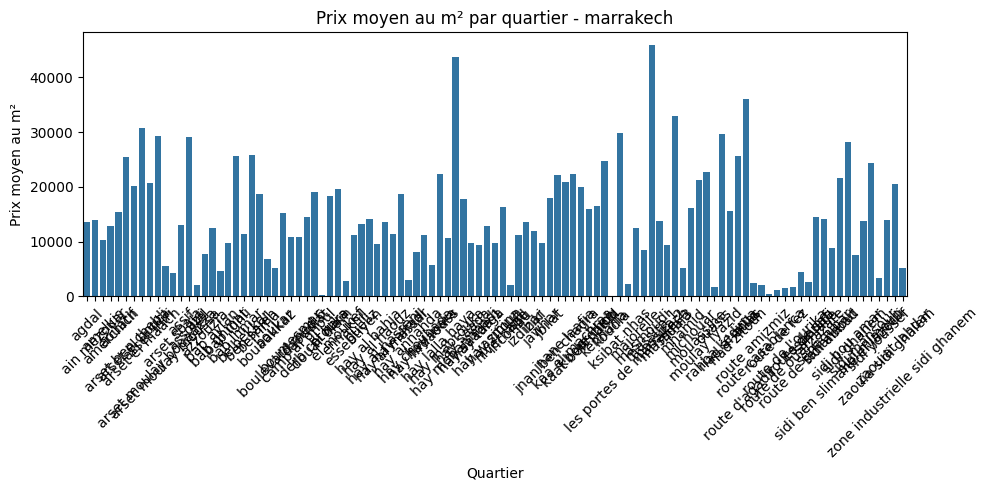

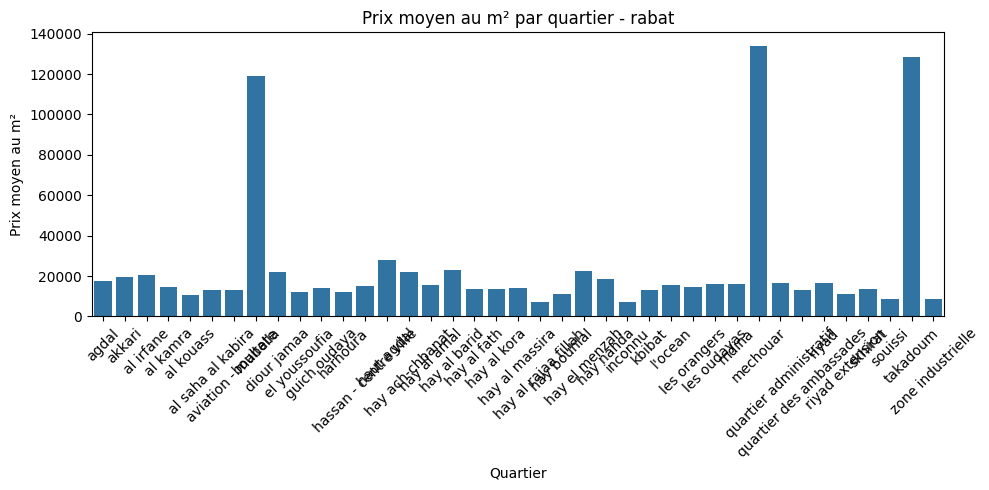

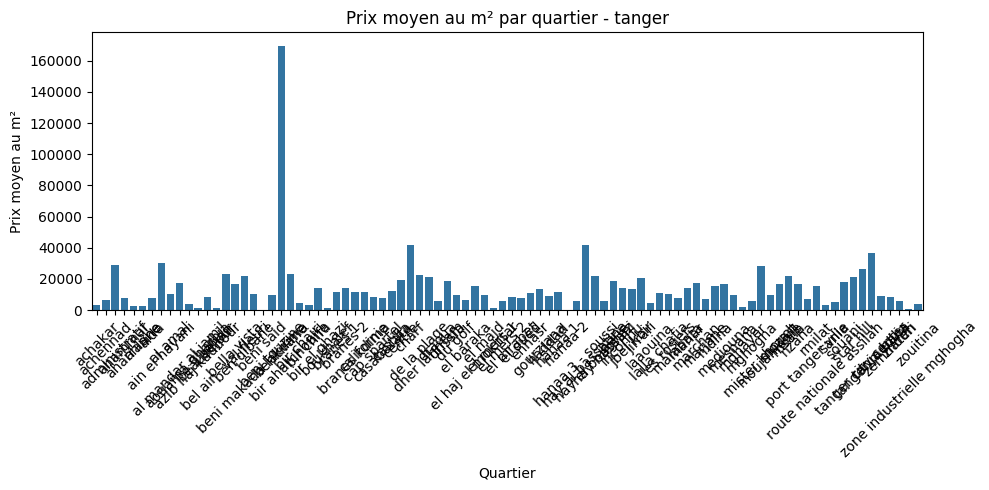

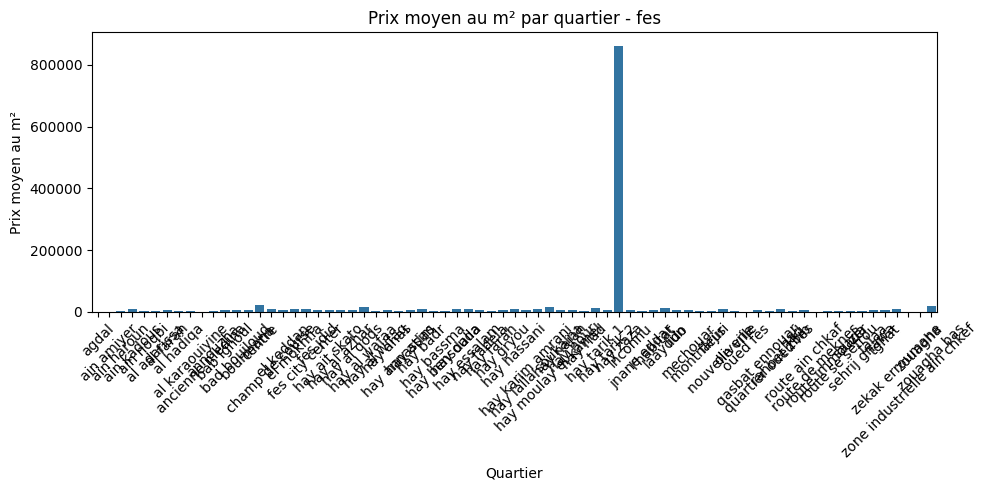

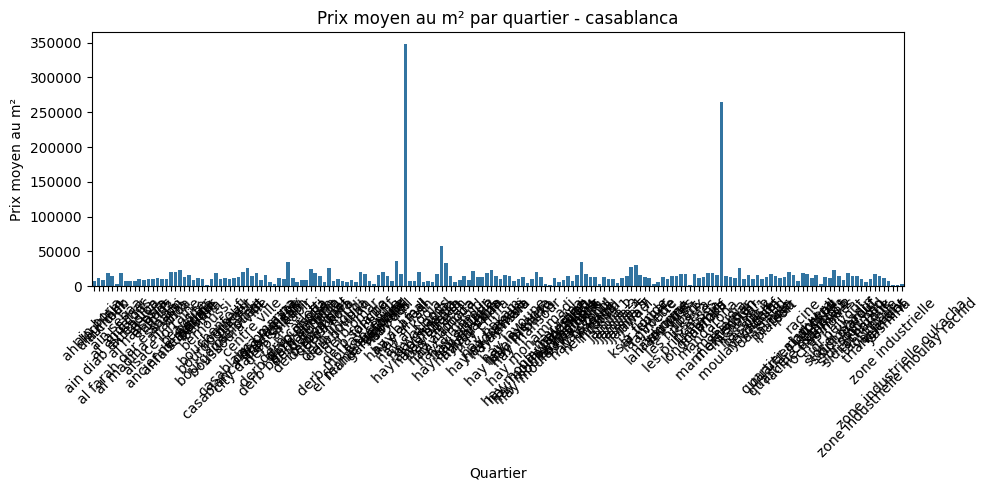

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

villes = df['ville'].unique()  # liste de toutes les villes

for ville in villes:
    df_ville = df[df['ville'] == ville]

    plt.figure(figsize=(10,5))
    sns.barplot(
        data=df_ville.groupby('quartier')['prix_m2_quartier'].mean().reset_index(),
        x='quartier',
        y='prix_m2_quartier'
    )
    plt.title(f"Prix moyen au m² par quartier - {ville}")
    plt.xlabel("Quartier")
    plt.ylabel("Prix moyen au m²")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



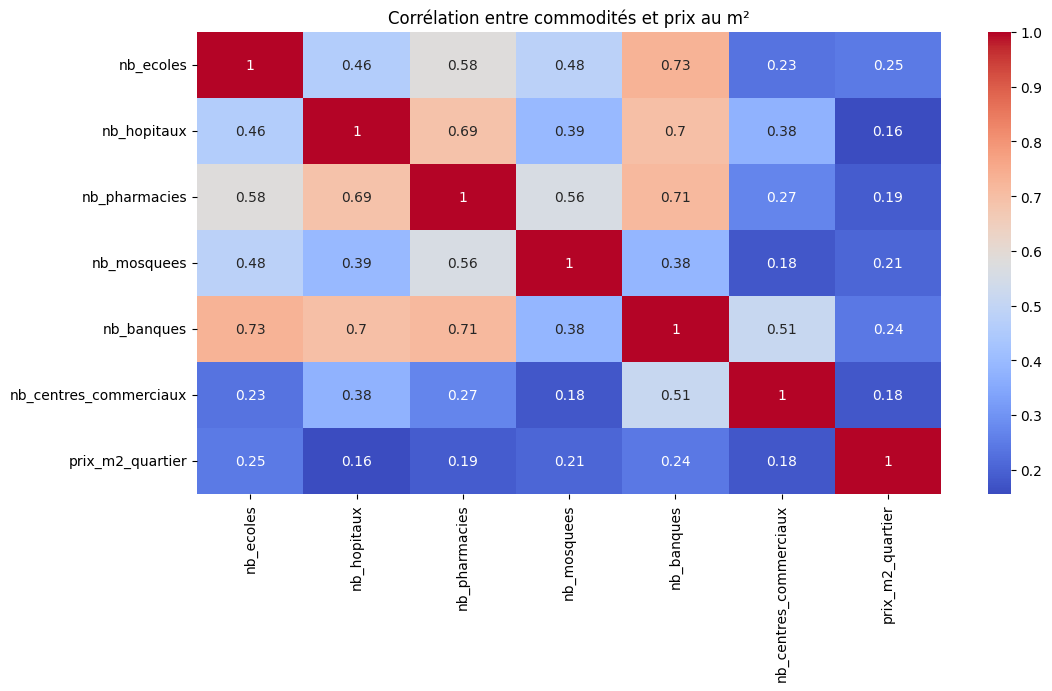

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

commodites = ['nb_ecoles', 'nb_hopitaux', 'nb_pharmacies', 'nb_mosquees', 'nb_banques', 'nb_centres_commerciaux']

plt.figure(figsize=(12,6))
sns.heatmap(df[commodites + ['prix_m2_quartier']].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre commodités et prix au m²")
plt.show()


In [ ]:
df[df.duplicated()].head()

,ville,quartier,prix,type_de_bien,surface,nombre_de_chambres,nombre_de_salles_de_bain,etage,terrasse,garage,...,quartier_key,lat,lon,nb_ecoles,nb_hopitaux,nb_pharmacies,nb_mosquees,nb_banques,nb_centres_commerciaux,prix_m2_quartier
29,agadir,hay houda,1320000.0,appartement,96.0,3.0,2.0,3.0,0,1,...,agadir_hay houda,30.399277,-9.538055,12,3,30,6,2,0,15202.939514
60,agadir,hay houda,805000.0,appartement,67.0,2.0,2.0,3.0,0,1,...,agadir_hay houda,30.399277,-9.538055,12,3,30,6,2,0,15202.939514
89,agadir,abattoirs,896000.0,local commercial,64.0,0.0,1.0,0.0,0,0,...,agadir_abattoirs,30.417131,-9.599245,8,5,29,7,32,1,10505.457026
93,agadir,hay houda,1320000.0,appartement,96.0,3.0,2.0,3.0,0,1,...,agadir_hay houda,30.399277,-9.538055,12,3,30,6,2,0,15202.939514
121,agadir,abattoirs,854000.0,local commercial,61.0,0.0,1.0,0.0,0,0,...,agadir_abattoirs,30.417131,-9.599245,8,5,29,7,32,1,10505.457026


In [ ]:
from sklearn.preprocessing import StandardScaler

commodites = [
    'nb_ecoles', 'nb_hopitaux', 'nb_pharmacies',
    'nb_mosquees', 'nb_banques', 'nb_centres_commerciaux'
]

# 1. Normaliser d'abord (moyenne=0, écart-type=1)
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[commodites]),
    columns=commodites,
    index=df.index
)

# 2. Calculer les corrélations (sur données normalisées)
correlations = df_scaled.join(df['prix_m2_quartier']).corr()['prix_m2_quartier'][commodites]

# 3. Ne garder QUE les corrélations positives
correlations_pos = correlations.clip(lower=0)

# 4. Normaliser en poids
if correlations_pos.sum() > 0:
    weights = correlations_pos / correlations_pos.sum()
else:
    weights = pd.Series(1/len(commodites), index=commodites)  # poids égaux si aucune corrélation positive

print("Corrélations :")
print(correlations.sort_values(ascending=False))
print("\nPoids finaux :")
print(weights.sort_values(ascending=False))

# 5. Créer le score (sur données normalisées)
df['score_commodites'] = df_scaled[commodites].mul(weights).sum(axis=1)

Corrélations :
nb_ecoles                 0.246768
nb_banques                0.243454
nb_mosquees               0.205709
nb_pharmacies             0.188454
nb_centres_commerciaux    0.175626
nb_hopitaux               0.155792
Name: prix_m2_quartier, dtype: float64

Poids finaux :
nb_ecoles                 0.202967
nb_banques                0.200242
nb_mosquees               0.169196
nb_pharmacies             0.155003
nb_centres_commerciaux    0.144453
nb_hopitaux               0.128139
Name: prix_m2_quartier, dtype: float64


In [ ]:
df.head()

,ville,quartier,prix,type_de_bien,surface,nombre_de_chambres,nombre_de_salles_de_bain,etage,terrasse,garage,...,lat,lon,nb_ecoles,nb_hopitaux,nb_pharmacies,nb_mosquees,nb_banques,nb_centres_commerciaux,prix_m2_quartier,score_commodites
0,agadir,haut founty,1750000.0,appartement,107.0,2.0,2.0,5.0,0,0,...,30.417131,-9.599245,8,5,29,7,32,1,10778.533510,-0.066845
1,agadir,founti,1282240.0,local commercial,110.0,0.0,1.0,1.0,0,0,...,30.395814,-9.580752,11,1,21,2,4,2,16885.607698,-0.352909
2,agadir,al wifaq,250000.0,local commercial,188.0,0.0,3.0,1.0,0,0,...,30.417131,-9.599245,8,5,29,7,32,1,15416.231506,-0.066845
3,agadir,ben serguaou,13900000.0,riad,430.0,5.0,4.0,0.0,1,1,...,30.389583,-9.575926,10,1,22,4,1,2,5459.825886,-0.328915
4,agadir,charaf,2200000.0,appartement,150.0,8.0,2.0,3.0,1,1,...,30.417131,-9.599245,8,5,29,7,32,1,18516.058394,-0.066845


In [ ]:
# One-Hot Encode de la colonne type_de_bien
df = pd.get_dummies(df, columns=['type_de_bien'], prefix='bien')

df.head()


,ville,quartier,prix,surface,nombre_de_chambres,nombre_de_salles_de_bain,etage,terrasse,garage,ascenseur,...,nb_centres_commerciaux,prix_m2_quartier,score_commodites,bien_appartement,bien_bureau,bien_local commercial,bien_maison,bien_riad,bien_terrain,bien_villa
0,agadir,haut founty,1750000.0,107.0,2.0,2.0,5.0,0,0,1,...,1,10778.533510,-0.066845,True,False,False,False,False,False,False
1,agadir,founti,1282240.0,110.0,0.0,1.0,1.0,0,0,0,...,2,16885.607698,-0.352909,False,False,True,False,False,False,False
2,agadir,al wifaq,250000.0,188.0,0.0,3.0,1.0,0,0,1,...,1,15416.231506,-0.066845,False,False,True,False,False,False,False
3,agadir,ben serguaou,13900000.0,430.0,5.0,4.0,0.0,1,1,0,...,2,5459.825886,-0.328915,False,False,False,False,True,False,False
4,agadir,charaf,2200000.0,150.0,8.0,2.0,3.0,1,1,1,...,1,18516.058394,-0.066845,True,False,False,False,False,False,False


In [ ]:
df.columns.tolist()

['ville',
 'quartier',
 'prix',
 'surface',
 'nombre_de_chambres',
 'nombre_de_salles_de_bain',
 'etage',
 'terrasse',
 'garage',
 'ascenseur',
 'piscine',
 'securite',
 'quartier_key',
 'lat',
 'lon',
 'nb_ecoles',
 'nb_hopitaux',
 'nb_pharmacies',
 'nb_mosquees',
 'nb_banques',
 'nb_centres_commerciaux',
 'prix_m2_quartier',
 'score_commodites',
 'bien_appartement',
 'bien_bureau',
 'bien_local commercial',
 'bien_maison',
 'bien_riad',
 'bien_terrain',
 'bien_villa']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17786 entries, 0 to 17785
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ville                     17786 non-null  object 
 1   quartier                  17786 non-null  object 
 2   prix                      17786 non-null  float64
 3   surface                   17786 non-null  float64
 4   nombre_de_chambres        17786 non-null  float64
 5   nombre_de_salles_de_bain  17786 non-null  float64
 6   etage                     17786 non-null  float64
 7   terrasse                  17786 non-null  int64  
 8   garage                    17786 non-null  int64  
 9   ascenseur                 17786 non-null  int64  
 10  piscine                   17786 non-null  int64  
 11  securite                  17786 non-null  int64  
 12  quartier_key              17786 non-null  object 
 13  lat                       17786 non-null  float64
 14  lon   

In [ ]:
df.to_csv("data_final.csv", index=False, encoding="utf-8")